In [4]:
# Load libraries. 
from pathlib import Path
#from utilities import ls, crawl
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
#from cloudpathlib import S3Path, S3Client
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu
from scipy import ndimage
from dipy.data import get_sphere
from dipy.direction import peaks_from_model
from dipy.direction import peaks_from_model
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram
from fury import actor, colormap
from visualization_utils import generate_anatomical_volume_figure

In [5]:
# Define paths for sub. 
sub01_bval_path = "/Users/la/Downloads/sub-NDARAB683CYD/dwi/sub-NDARAB683CYD_acq-64dir_dwi.bval"
sub01_bvec_path = "/Users/la/Downloads/sub-NDARAB683CYD/dwi/sub-NDARAB683CYD_acq-64dir_dwi.bvec"
sub01_dwi_path = "/Users/la/Downloads/sub-NDARAB683CYD/dwi/sub-NDARAB683CYD_acq-64dir_dwi.nii.gz"



In [6]:
# Load dwi data and affine matrix.
sub01_dwi_img = nib.load(sub01_dwi_path)
sub01_affine = sub01_dwi_img.affine

# Load bvals and bvecs.
sub01_bvals, sub01_bvecs = read_bvals_bvecs(sub01_bval_path, sub01_bvec_path)

print("bval file has a shape of: ", sub01_bvals.shape)  
print("bvec file has a shape of: ", sub01_bvecs.shape)

sub01_gtab = gradient_table(sub01_bvals, sub01_bvecs)
sub01_gtab

bval file has a shape of:  (129,)
bvec file has a shape of:  (129, 3)


In [7]:
sub01_gtab.info

B-values shape (129,)
         min 0.000000
         max 2000.000000
B-vectors shape (129, 3)
          min -0.964209
          max 0.999994



In [8]:
from nilearn.plotting import plot_roi
# Load dwi data and mask.
sub01_dwi_data = sub01_dwi_img.get_fdata()
sub01_dwi_data, sub01_dwi_mask = median_otsu(sub01_dwi_data, vol_idx=[0], numpass=1)  # Specify the volume index to the b0 volumes

print("dwi data has a shape of: ", sub01_dwi_data.shape)
print("dwi mask has a shape of: ", sub01_dwi_mask.shape)

#plot_roi(sub01_dwi_mask, display_mode='z', cut_coords=1, title="Mask on DWI data")


dwi data has a shape of:  (104, 104, 72, 129)
dwi mask has a shape of:  (104, 104, 72)


Text(0.5, 1.0, 'Mask data')

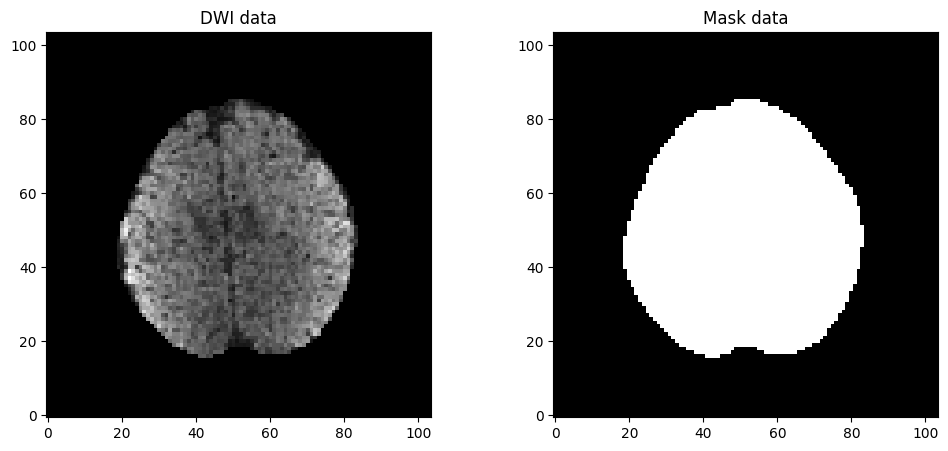

In [9]:


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow((sub01_dwi_data[:, :, 50, 1].astype('float')).T, cmap='gray', origin='lower')
ax[0].set_title('DWI data')

ax[1].imshow((sub01_dwi_mask[:, :, 50].astype('float')).T, cmap='gray', origin='lower')
ax[1].set_title('Mask data')


In [10]:
# Creat tensor model object and fit to the data.
sub01_dti_model = dti.TensorModel(sub01_gtab)
sub01_dti_fit = sub01_dti_model.fit(sub01_dwi_data, mask=sub01_dwi_mask) 

sub01_dti_fit

Text(0.5, 1.0, 'EVECS data')

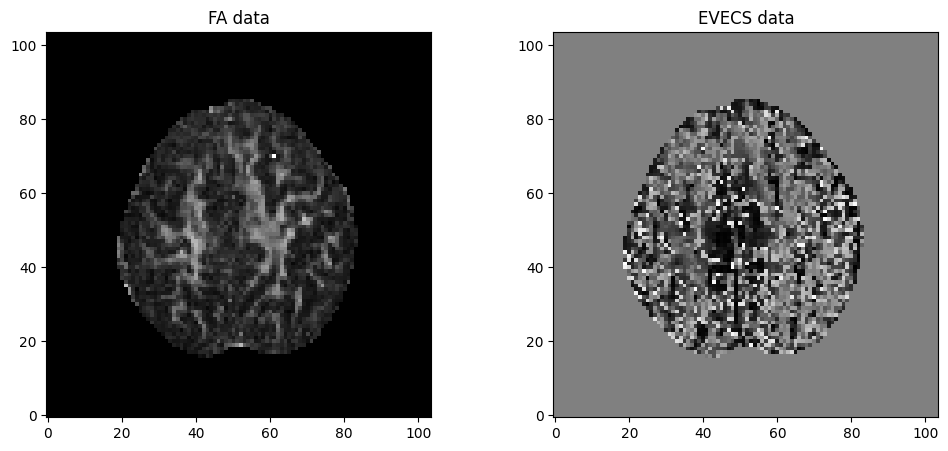

In [11]:
# Define output directory. 
#output_dir = "/Users/la/Downloads/sub-NDARAB683CYD/dwi"

# Get FA and EVECS data.
sub01_fa_img = sub01_dti_fit.fa
sub01_evecs_img = sub01_dti_fit.evecs

# Turn nans to 0. 
sub01_fa_img[np.isnan(sub01_fa_img)] = 0

# Turn FA into nifti object.
fa_nii = nib.Nifti1Image(sub01_fa_img.astype(np.float32), sub01_affine)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow((sub01_fa_img[:, :, 50].astype('float')).T, cmap='gray', origin='lower')
ax[0].set_title('FA data')

ax[1].imshow((sub01_evecs_img[:, :, 50, 0, 0].astype('float')).T, cmap='gray', origin='lower')
ax[1].set_title('EVECS data')




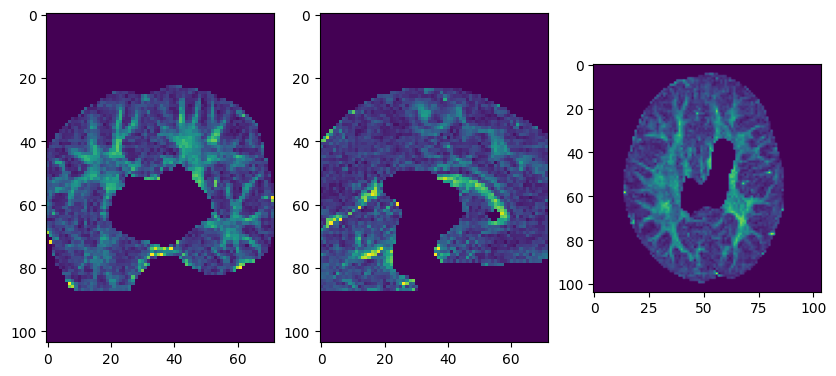

In [12]:
# Nicer image for FA data. 

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(ndimage.rotate(sub01_fa_img[:, sub01_fa_img.shape[1]//2, :], 90, reshape=False))
ax[1].imshow(ndimage.rotate(sub01_fa_img[sub01_fa_img.shape[0]//2, :, :], 90, reshape=False))
ax[2].imshow(ndimage.rotate(sub01_fa_img[:, :, sub01_fa_img.shape[-1]//2], 90, reshape=False))
#fig.savefig(os.path.join(out_dir, "fa.png"), dpi=300, bbox_inches="tight")
plt.show()

In [13]:

# Get sphere object.
sphere = get_sphere('symmetric362')

# Get peaks from model.
peak_indices = peaks_from_model(
    model=sub01_dti_model, data=sub01_dwi_data, sphere=sphere, relative_peak_threshold=.2,
    min_separation_angle=25, mask=sub01_dwi_mask, npeaks=2)


stopping_criterion = ThresholdStoppingCriterion(sub01_fa_img, .2)

seed_mask = sub01_fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=sub01_affine, density=1)

# Initialize local tracking - computation happens in the next step.
streamlines_generator = LocalTracking(
    peak_indices, stopping_criterion, seeds, affine=sub01_affine, step_size=.5)

# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

/opt/anaconda3/envs/nipy/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: UserWarning: We'll no longer accept the way you call the line function in future versions of FURY.

Here's how to call the Function line: line(lines_value, colors='value', opacity='value', linewidth='value', spline_subdiv='value', lod='value', lod_points='value', lod_points_size='value', lookup_colormap='value', depth_cue='value', fake_tube='value')

  exec(code_obj, self.user_global_ns, self.user_ns)


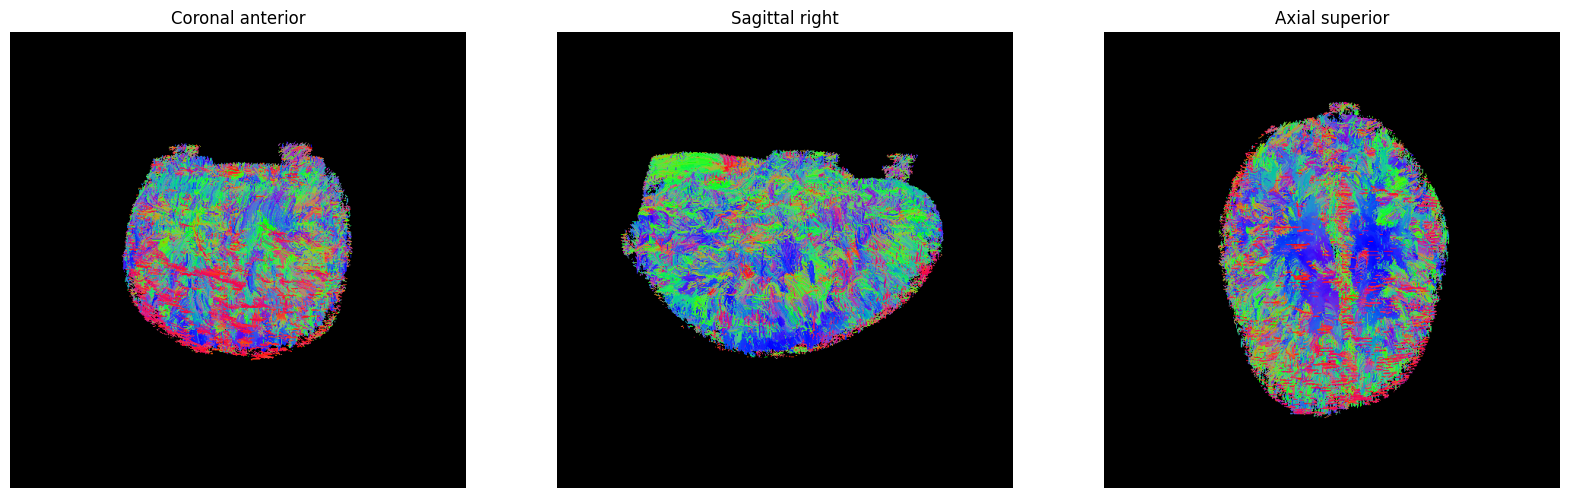

In [14]:


sft = StatefulTractogram(streamlines, sub01_dwi_img, Space.RASMM)

# Build the representation of the data
streamlines_actor = actor.line(streamlines, colormap.line_colors(streamlines))

# Generate the figure
fig = generate_anatomical_volume_figure(streamlines_actor)

plt.show()